

# **IFI8410: Programming for Business**



## **Assignment 08**

In [1]:
# Do not change the content of this cell. Execute this cell first, and everytime after you restarted the kernel.
%reload_ext autoreload
%autoreload 2

## Information-Based Learning

### 8.1 Load Data, Split in Train and Test Sets

Question:

You are given a CSV file **Fraud.csv**:

- Write a function **split_data_set** that takes in a DataFrame and a fraction **frac** and splits the DataFrame into two separate DataFrames. 
- The first DataFrame should contain a random selection of **frac** percent of the original rows, and the second DataFrame should contain the remaining rows. 
- For example, if frac is 0.8, the function should return one DataFrame with 80% of the rows and a second DataFrame with the remaining 20%.

Hint:

- Use **pandas.DataFrame.sample** to select frac percent of the rows for the first DataFrame. 
- Then, use the complement of this sample for the second DataFrame by selecting rows not in the first DataFrame’s index.

In [2]:
import pandas as pd
from typing import Set, List, Tuple, Any
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

def split_data_set(df: pd.DataFrame, ratio: float) -> (pd.DataFrame, pd.DataFrame):
    
    # Write your code here
    


In [3]:
# Example usage:
df = pd.read_csv('/data/IFI8410/sess10/Fraud_data.csv')
df_80, df_20 = split_data_set(df, 0.8)
print(f"Number of records: {len(df)}")
print(f"Number of rows in Training-Set: {len(df_80)}")
print(f"Number of rows in Test-Set: {len(df_20)}")

Number of records: 500
Number of rows in Training-Set: 400
Number of rows in Test-Set: 100


#### Save your solution to a file ...

In [4]:
%%writefile solution_8_1.py

import pandas as pd

def split_data_set(df: pd.DataFrame, ratio: float) -> (pd.DataFrame, pd.DataFrame):




Overwriting solution_8_1.py


#### Test 8.1 Execute the cell below to test your solution...

In [5]:
! test/run_test.sh 1

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_01.py .                                                   [100%]

============================== 1 passed in 0.45s ===============================
Testing completed.


### 8.2 One-Hot-Encoding

Question:

Define a function that creates and fits a **One-Hot Encoder** for a given DataFrame and a list of categorical features to be transformed. 

The function should return an encoder object that can be re-used for future transformations of similar data.

Requirements:

- Handle unknown categories by ignoring them.
- Drop the first level in each one-hot-encoded vector to reduce dimensionality.
- Produce a dense output matrix (not sparse).

Hint
- To implement this, use the **OneHotEncoder** from **sklearn.preprocessing**. 
- Ignore unknown categories during transformation.
- Drop the first column of each one-hot-encoded feature to avoid collinearity.
- Set the output to a dense array instead of a sparse matrix.

In [7]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def create_one_hot_encoder(df: pd.DataFrame, categorical_features: list) -> OneHotEncoder:
    
    # Write your code here
    



In [8]:
# Example usage:
# Load the CSV file into a DataFrame
df = pd.read_csv('/data/IFI8410/sess10/Fraud_data.csv')

# Define the list of categorical features to encode
categorical_features = [
    'Make', 'AccidentArea', 'Sex', 'MaritalStatus', 'Fault',
    'PolicyType', 'VehicleCategory', 'PoliceReportFiled',
    'WitnessPresent', 'BasePolicy'
]

# Create and fit the one-hot encoder
encoder = create_one_hot_encoder(df, categorical_features)

# Display categories in the encoder to confirm it was fitted correctly
print("Categories in encoder:", encoder.categories_)

Categories in encoder: [array(['Accura', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda',
       'Mazda', 'Nisson', 'Pontiac', 'Saab', 'Saturn', 'Toyota', 'VW'],
      dtype=object), array(['Rural', 'Urban'], dtype=object), array(['Female', 'Male'], dtype=object), array(['Divorced', 'Married', 'Single', 'Widow'], dtype=object), array(['Policy Holder', 'Third Party'], dtype=object), array(['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability',
       'Sport - All Perils', 'Sport - Collision', 'Utility - All Perils',
       'Utility - Collision'], dtype=object), array(['Sedan', 'Sport', 'Utility'], dtype=object), array(['No', 'Yes'], dtype=object), array(['No', 'Yes'], dtype=object), array(['All Perils', 'Collision', 'Liability'], dtype=object)]


#### Save your solution to a file ...

In [9]:
%%writefile solution_8_2.py

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def create_one_hot_encoder(df: pd.DataFrame, categorical_features: list) -> OneHotEncoder:



Overwriting solution_8_2.py


#### Test 8.2 Execute the cell below to test your solution...

In [10]:
! test/run_test.sh 2

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_02.py .                                                   [100%]

============================== 1 passed in 0.80s ===============================
Testing completed.


### 8.3 Prediction and Accuracy for Decision Tree Model

Question:

- Train a **Decision Tree Model** on a fraud dataset:

- Write a function that processes the **Fraud_data.csv** dataset and trains a **Decision Tree classifier** to predict fraud. 

Your task is to:

- Load and preprocess the data by one-hot encoding categorical columns.
- Split the dataset into training and test sets with a 70:30 ratio.
- Train a **DecisionTreeClassifier** model using the training data.
- Evaluate the model using accuracy, precision, recall, and F1-score on the test set.

Requirements:

- Use a `OneHotEncoder` to encode categorical features, ensuring unknown levels are ignored. 
- The first category is dropped, and dense output is returned.
- Return the calculated metrics **accuracy, precision, recall, F1-score** on the test set in the function output.

Hint :

- One-Hot Encoding: Apply `OneHotEncoder` on the categorical columns, setting parameters to ignore unknown values, drop the first level, and return a dense matrix.

- Splitting the Data: Use `train_test_split` with a 70% train and 30% test split.

- Model Training: Use `DecisionTreeClassifier` to train on the training data.

- Metrics Calculation: Use scikit-learn’s `accuracy_score`, `precision_score`, `recall_score`, and `f1_score` functions.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def process_and_train_decision_tree(df: pd.DataFrame, categorical_features: list) -> None:
    
    # Write your code here
        


    

In [13]:
# Example usage:
# Load the dataset
file_path = '/data/IFI8410/sess10/Fraud_data.csv'
df = pd.read_csv(file_path)

# Define categorical columns
categorical_features = [
    'Make', 'AccidentArea', 'Sex', 'MaritalStatus', 'Fault',
    'PolicyType', 'VehicleCategory', 'PoliceReportFiled',
    'WitnessPresent', 'BasePolicy'
]

# Run the training and evaluation function
process_and_train_decision_tree(df, categorical_features)

Accuracy: 0.88
Precision: 0.20
Recall: 0.33
F1-Score: 0.25


(0.88, 0.2, 0.3333333333333333, 0.25)

#### Save your solution to a file ...

In [14]:
%%writefile solution_8_3.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def process_and_train_decision_tree(df: pd.DataFrame, categorical_features: list) -> None:
    
 

Overwriting solution_8_3.py


#### Test 8.3 Execute the cell below to test your solution...

In [15]:
! test/run_test.sh 3

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_03.py .                                                   [100%]

============================== 1 passed in 0.88s ===============================
Testing completed.


### 8.4 Prediction and Accuracy for XGBOOST Model

Question

- Train a Decision Tree Model on Fraud Data.

- Write a function that processes the Fraud_data.csv dataset and trains an **XGBOOST** classification model to predict fraud. 

Your task is to:

- Load and preprocess the data by one-hot encoding categorical columns.
- Split the dataset into training and test sets with a 70:30 ratio.
- Train a **XGBOOST classifier** model using the training data.
- Evaluate the model using **accuracy, precision, recall, and F1-score** on the test set.

Requirements:

- Use a `OneHotEncoder` to encode categorical features, ensuring unknown levels are ignored. 
- The first category is dropped, and dense output is returned.
- Return the calculated metrics **accuracy, precision, recall, F1-score** on the test set in the function output.

Hint:

- Use `XGBClassifier` from scikit-learn.


In [17]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.8 -m pip install --upgrade pip


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def process_and_train_xgboost(df: pd.DataFrame, categorical_features: list) -> None:
    
    # Write your code here
    


In [19]:
# Example usage:
file_path = '/data/IFI8410/sess10/Fraud_data.csv'
df = pd.read_csv(file_path)

categorical_features = [
    'Make', 'AccidentArea', 'Sex', 'MaritalStatus', 'Fault',
    'PolicyType', 'VehicleCategory', 'PoliceReportFiled',
    'WitnessPresent', 'BasePolicy'
]

process_and_train_xgboost(df, categorical_features)

Class distribution: {0: 467, 1: 33}
Prediction distribution: {0: 143, 1: 7}

Accuracy: 0.91
Precision: 0.14
Recall: 0.11
F1-Score: 0.12


(0.9066666666666666, 0.14285714285714285, 0.1111111111111111, 0.125)

#### Save your solution to a file ...

In [20]:
%%writefile solution_8_4.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def process_and_train_xgboost(df: pd.DataFrame, categorical_features: list) -> None:
    
    # Write your code here
    



Overwriting solution_8_4.py


#### Test 8.4 Execute the cell below to test your solution...

In [21]:
! test/run_test.sh 4

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_04.py .                                                   [100%]

============================== 1 passed in 1.04s ===============================
Testing completed.


### 8.5 Model Evaluation

Question:

- Write a function `evaluate_classification` to evaluate the predictions of a decision tree model on a fraud detection dataset. 

- This function takes as input the vector of actual labels **y_actual** and the vector of predicted labels **y_pred**.

- This function should count the number of **True Positives, False Negatives, False Positives,** and **True Negatives** and then display the results in a summary table.

Hint:

Use `np.sum` and logical conditions to count occurrences of each type:

- **True Positive:** when the actual and predicted values are both True
- **False Negative:** when the actual value is True and predicted is False
- **False Positive:** when the actual value is False and predicted is True
- **True Negative:** when both are False


#### Setting up the classification model (DO NOT MODIFY THIS CODE HERE!)

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

# Load data
file_path = '/data/IFI8410/sess10/Fraud_data.csv'
df = pd.read_csv(file_path)

# Define features
categorical_features = [
    'Make', 'AccidentArea', 'Sex', 'MaritalStatus', 'Fault',
    'PolicyType', 'VehicleCategory', 'PoliceReportFiled',
    'WitnessPresent', 'BasePolicy'
]
target_feature = 'FraudFound_P'

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_cat = encoder.fit_transform(df[categorical_features])

# Enhanced cleaning function to handle ranges, units, and 'none' values
def clean_numerical_data(value):
    if isinstance(value, str):
        # Convert ranges to midpoints
        if 'to' in value:
            start, end = map(int, value.split(' to '))
            return (start + end) / 2
        # Extract numbers from text with units like "5 years" or "1 vehicle"
        elif any(char.isdigit() for char in value):
            return int(''.join(filter(str.isdigit, value)))  # Extracts numeric part only
        # Handle cases like 'none' or other strings by returning NaN
        else:
            return np.nan
    return value  # Return value if already numeric

# Apply cleaning function to numerical data
df_num = df.drop(columns=[target_feature] + categorical_features)
df_num = df_num.applymap(clean_numerical_data)

# Handle NaNs by replacing them with the column mean
imputer = SimpleImputer(strategy='mean')
X_num = imputer.fit_transform(df_num)

# Prepare feature matrix and target vector
X = np.hstack([X_cat, X_num])
y = df[target_feature].values

# Split data and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

#### Define your evaluation function below:

In [24]:
def evaluate_classification(y_actual, y_pred):

    # Write your code here:
    


In [25]:
# Try your code here:
TP, FN, FP, TN = evaluate_classification(y_test, y_pred)

# Print results
print(f"""
              | Predicted
              | True  False
--------------+------------------
Actual True   | {TP:4d}   {FN:4d}
       False  | {FP:4d}   {TN:4d}
""")


              | Predicted
              | True  False
--------------+------------------
Actual True   |    3      6
       False  |   10    131



#### Save your solution to a file ...

In [26]:
%%writefile solution_8_5.py

import numpy as np

def evaluate_classification(y_actual, y_pred):




Overwriting solution_8_5.py


#### Test 8.5 Execute the cell below to test your solution...

In [27]:
! test/run_test.sh 5

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_05.py .                                                   [100%]

============================== 1 passed in 0.15s ===============================
Testing completed.


## Similarity-Based Learning

### 8.6: Implement a Robust KNN Classifier

You are given a dataset with several features and a target column. Your task is to implement a **KNN classifier** that includes necessary preprocessing steps to handle both categorical and numerical data. 

The aim is to build a reliable KNN model using **k=2** with optimized preprocessing.


**Problem Statement:**

Implement the function `knn_classifier` that will:

- Take a dataset (as a DataFrame), a list of feature columns (**X**), and a target column (**y**) as input.

- Apply preprocessing to handle both categorical and numerical features:

- Use **One-Hot Encoding** for categorical features.

- Apply **Standard Scaling** to numerical features.

- Transform string labels in target column **y** into 0 and 1 as labels via **Label Encoding** if necessary.

- Train a KNN classifier using k=2.


Evaluate the classifier using the testing set and provide the following:

- The accuracy of the classifier.

- A classification report that includes metrics like precision, recall, and F1-score.

- Return the **accuracy** and the **classification report**.


**Hint:**
- Use as feature columns **'WeekOfMonth', 'AccidentArea', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'VehicleCategory', 'Deductible', 'DriverRating', 'PoliceReportFiled'**.
- Use as target columnn **'BasePolicy'**.
- Use the `OneHotEncoder` from **sklearn.preprocessing** for categorical variables.
- Use `StandardScaler` to scale numerical features.
- Use `LabelEncoder` for **Label Encoding** of target feature **y**.
- Use `KNeighborsClassifier` for the kNN classifier model.
- Utilize `Pipeline` and `ColumnTransformer` to streamline the preprocessing and model training.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

import pandas as pd

def knn_classifier(data, feature_columns, target_column, k=2):
    
    # Write your code here




In [30]:
# Example usage:

# Load the dataset
df6 = pd.read_csv('/data/IFI8410/sess10/reduced_fraud_oracle.csv')

# Define the features and target
feature_columns = ['WeekOfMonth', 'AccidentArea', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'VehicleCategory', 'Deductible', 'DriverRating', 'PoliceReportFiled']
target_column = 'BasePolicy'

# Call the classifier function
accuracy, report = knn_classifier(df6, feature_columns, target_column)

# Display the results
print("Accuracy of KNN Classifier (k=2):", accuracy)
print("Classification Report:\n", report)

Accuracy of KNN Classifier (k=2): 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.71      0.53        35
           1       0.57      0.41      0.48        66
           2       0.86      0.78      0.82        49

    accuracy                           0.60       150
   macro avg       0.62      0.63      0.61       150
weighted avg       0.63      0.60      0.60       150



#### Save your solution to a file

In [31]:
%%writefile solution_8_6.py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

import pandas as pd

def knn_classifier(data, feature_columns, target_column, k=2):




Overwriting solution_8_6.py


#### Test 8.6 Execute the cell below to test your solution...

In [32]:
! test/run_test.sh 6

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_06.py .                                                   [100%]

============================== 1 passed in 0.96s ===============================
Testing completed.


### 8.7 KNN Classifier for Insurance Use Case

**Problem Statement:**

You are given a dataset that contains insurance information, including features related to accidents and claims. 

Create the following function `knn_fraud_detection` that should:

- Implement a `KNN classifier` with **k=3** to predict whether a claim is fraudulent (**FraudFound_P**).

- Use the entire dataset provided, but an example illustration uses the first 5 rows for clarity.

- Use relevant features **VehiclePrice, Age, DriverRating, VehicleCategory, PastNumberOfClaims** to train the model.

- Evaluate the classifier on the entire dataset and return its accuracy and a classification report.


**Hint**:

- Select as feature columns **VehiclePrice, Age, DriverRating, VehicleCategory, PastNumberOfClaims**.
  
- Select as target column **FraudFound_P**.

- Handle missing or categorical data appropriately before training.

- Consider encoding categorical features like **VehiclePrice** and **VehicleCategory** using `LabelEncoder`.

- Use again `KNeighborsClassifier` for the kNN classifier model.

- Use `train_test_split` to split the dataset into training and testing sets.

- Use metrics like `accuracy_score` and `classification_report` to assess the performance.


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

def knn_fraud_detection(data):
    
    # Write your code here





In [35]:
# Example:

# Load the dataset
df = pd.read_csv('/data/IFI8410/sess10/reduced_fraud_oracle.csv')

# Call the function using the full dataset
accuracy, report = knn_fraud_detection(df)

# Display the full dataset results
print("\nAccuracy of KNN Fraud Detection (k=3) - Data:", accuracy)
print("Classification Report for Data:\n", report)



Accuracy of KNN Fraud Detection (k=3) - Data: 0.94
Classification Report for Data:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       142
           1       0.00      0.00      0.00         8

    accuracy                           0.94       150
   macro avg       0.47      0.50      0.48       150
weighted avg       0.90      0.94      0.92       150



#### Save your solution to a file

In [36]:
%%writefile solution_8_7.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

def knn_fraud_detection(data):





Overwriting solution_8_7.py


#### Test 8.7 Execute the cell below to test your solution...

In [37]:
! test/run_test.sh 7

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_07.py .                                                   [100%]

============================== 1 passed in 0.83s ===============================
Testing completed.


### 8.8 Visualize KNN Classifier Results with Confusion Matrix

In this problem, you'll implement a function to visualize the performance of a **KNN classifier** using a **confusion matrix**. 

The plot should clearly show the number of **True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)**.

The KNN model should be trained on a dataset, and you will use a confusion matrix to show how well the classifier performs.

The function should take the trained KNN classifier's predictions and visualize these metrics using a heatmap.


**Problem Description**:

You are given a dataset with features and target labels for fraud detection.

Implement the `knn_plot_confusion_matrix` function that:

- Trains a KNN classifier with k=3.

- Plots a confusion matrix that shows the counts of TP, TN, FP, and FN.

- Uses the **seaborn** and **matplotlib** libraries for visualization.

- Inputs to the function are the DataFrame **data**, the feature columns **feature_columns** (as list of column names) and the target column **target_column**.


**Function Requirements**:

- The function should train the KNN classifier.

- Generate predictions on the test set.

- Plot a confusion matrix using `seaborn.heatmap`.

- Ensure that the plot is annotated with counts for TP, TN, FP, and FN.

- Add a title 'Confusion Matrix of KNN Classifier (k=3)'. Add axes labels 'Predicted Labels' for x-axis and 'Actual Labels' for y-axis.


**Hint**:

- Use the `confusion_matrix` method from scikit-learn.
- Look at problem 8.7 to create a similar setup for your model training and prediction.
- You can use the same DataFrame and feature colunns and target column as in 8.7 to try out your function.


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

def knn_plot_confusion_matrix(data, feature_columns, target_column):
    
    # Write your code here





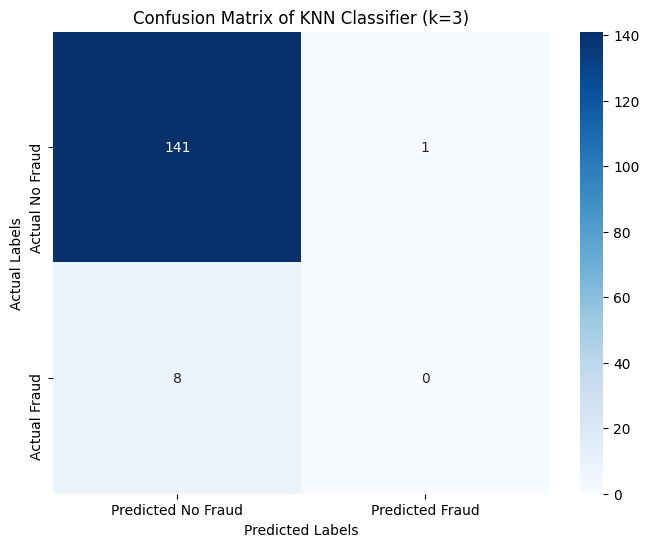

In [40]:
# Try out your function:

# Load the dataset
df = pd.read_csv('/data/IFI8410/sess10/reduced_fraud_oracle.csv')
feature_columns = ['VehiclePrice', 'Age', 'DriverRating', 'VehicleCategory', 'PastNumberOfClaims']
target_column = 'FraudFound_P'

# Call the visualization function
knn_plot_confusion_matrix(df, feature_columns, target_column)


#### Save your solution to a file ...

In [41]:
%%writefile solution_8_8.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

def knn_plot_confusion_matrix(data, feature_columns, target_column):




Overwriting solution_8_8.py


#### Test 8.8 Execute the cell below to test your solution...

In [42]:
! test/run_test.sh 8

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_08.py .                                                   [100%]

============================== 1 passed in 1.51s ===============================
Testing completed.


### 8.9 Implement KNN for Fraud Probability Prediction

In this problem, you will use a **KNN classifier** to predict the probability that a transaction is fraudulent.
 
Instead of simply predicting a binary outcome (fraud or no fraud), your task is to output the probability of fraud for each transaction. 

This involves using the `predict_proba` method in **sklearn's** `KNeighborsClassifier`.


**Problem Description**:

- You are given a dataset containing transactions, some of which are fraudulent.

- Train a KNN classifier with k=5 to predict whether a transaction is fraudulent.

- Use the model to output the probability that each transaction is fraudulent.

- Implement a function to calculate the predicted probabilities and display the results.

- Implement a `knn_fraud_probability` function that trains a KNN classifier using **k=5**.

- Output the probability that a transaction is fraudulent using the method `predict_proba`.

- Return a DataFrame that contains exactly the top 5 transactions with the highest probability of being fraudulent sorted in descending order. The fraud probabilities should be contained in a column named **Fraud_Probability** with its values sorted in descending order. The returned DataFrame should include an additional column named **Actual_Label** .


**Hint**:

- Select as feature columns **VehiclePrice, Age, DriverRating, VehicleCategory, PastNumberOfClaims**.
  
- Select as target column **FraudFound_P**.
    

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def knn_fraud_probability(data):
    
    # Write your code here




In [45]:
# Load the dataset
df2 = pd.read_csv('//data/IFI8410/sess10/reduced_fraud_oracle.csv')

# Call the function
fraud_probabilities = knn_fraud_probability(df2)

# Display the results
print("\nTop 5 Transactions with Highest Fraud Probability:")
print(fraud_probabilities)



Top 5 Transactions with Highest Fraud Probability:
     VehiclePrice  Age  DriverRating  VehicleCategory  PastNumberOfClaims  \
394             5   30             2                1                   0   
117             1   29             2                0                   1   
90              5   31             1                0                   1   
475             1   54             4                0                   3   
82              0   37             4                1                   2   

     Fraud_Probability  Actual_Label  
394                0.4             0  
117                0.4             0  
90                 0.4             0  
475                0.4             0  
82                 0.4             0  


#### Save your solution to a file ...

In [46]:
%%writefile solution_8_9.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def knn_fraud_probability(data):




Overwriting solution_8_9.py


#### Test 8.9 Execute the cell below to test your solution...

In [47]:
! test/run_test.sh 9

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_09.py .                                                   [100%]

============================== 1 passed in 0.87s ===============================
Testing completed.


### 8.10 Implement a Hybrid Model using XGBoost and Random Forest for Fraud Detection

**Problem Description**:

- You are given a dataset containing transaction data, some of which are fraudulent.

- Implement a function called `hybrid_fraud_detection` that:

- Trains an **XGBoost model** and a **Random Forest model** to predict fraudulent transactions using the same dataset.

- Implements a voting mechanism that combines the predictions from both models.

- Outputs the **accuracy** and **classification report** of the combined model.

**Hint**:

- Use the `VotingClassifier` function from **scikit-learn** via a function call `VotingClassifier(estimators=[('xgb', xgb), ('rf', rf)], voting='soft')` to combine both models.
- Then perform model training and prediction with the combined model similar to problem 8.7.
  

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

def hybrid_fraud_detection(data):
    
    # Write your code here





In [50]:
# Load the dataset
df3 = pd.read_csv('/data/IFI8410/sess10/reduced_fraud_oracle.csv')

# Call the hybrid model function
accuracy, report = hybrid_fraud_detection(df3)

# Display the results
print("\nAccuracy of Hybrid Fraud Detection Model (XGBoost + Random Forest):", accuracy)
print("Classification Report:\n", report)



Accuracy of Hybrid Fraud Detection Model (XGBoost + Random Forest): 0.9266666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       142
           1       0.00      0.00      0.00         8

    accuracy                           0.93       150
   macro avg       0.47      0.49      0.48       150
weighted avg       0.90      0.93      0.91       150



#### Save your solution to a file ...

In [51]:
%%writefile solution_8_10.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

def hybrid_fraud_detection(data):
    # Define relevant features and the target
    feature_columns = ['VehiclePrice', 'Age', 'DriverRating', 'VehicleCategory', 'PastNumberOfClaims']
    target_column = 'FraudFound_P'

    # Extract features (X) and target (y)
    X = data[feature_columns].copy()
    y = data[target_column]

    # Encode categorical features if necessary
    label_encoders = {}
    for column in X.columns:
        if X[column].dtype == 'object':
            le = LabelEncoder()
            X[column] = le.fit_transform(X[column])
            label_encoders[column] = le

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the models
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Create a Voting Classifier with 'soft' voting
    voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('rf', rf)], voting='soft')

    # Train the combined model
    voting_clf.fit(X_train, y_train)

    # Predict the target labels on the test set
    y_pred = voting_clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate a classification report
    report = classification_report(y_test, y_pred, zero_division=0)

    return accuracy, report


Overwriting solution_8_10.py


#### Test 8.10 Execute the cell below to test your solution...

In [52]:
! test/run_test.sh 10

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_10.py .                                                   [100%]

============================== 1 passed in 1.19s ===============================
Testing completed.


# Run all the tests again ...

In [54]:
! ./test/run_test.sh

============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_01.py .                                                   [100%]

============================== 1 passed in 0.41s ===============================
============================= test session starts ==============================
platform linux -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1
rootdir: /home/mjack6/IFI8410_class/IFI8410F24/IFI8410-Development/Fall2024/HW08
plugins: anyio-4.2.0
collected 1 item                                                               

test/test_hw08_02.py .                                                   [100%]

============================== 1 passed in 0.80s ===============================
======

#Homework Submission

- This homework is due by **2024-11-06, 6:00 PM (EDT)**.

- Make sure that all your programs and output files are in the exact folder as specified in the instructions.

- All file names on this system are case sensitive. Verify if you copy your work from a local computer to your home directory on ARC.

**Execute the cell below to submit your assignment**

In [55]:
! ./submit.sh -y

*******************************************
*  You are about to submit Homework HW08  *
*******************************************

Any files that you previously submitted will
be overwritten by your current files.

.....SUBMIT 'solution_8_1.py'
.....SUBMIT 'solution_8_2.py'
.....SUBMIT 'solution_8_3.py'
.....SUBMIT 'solution_8_4.py'
.....SUBMIT 'solution_8_5.py'
.....SUBMIT 'solution_8_6.py'
.....SUBMIT 'solution_8_7.py'
.....SUBMIT 'solution_8_8.py'
.....SUBMIT 'solution_8_9.py'
.....SUBMIT 'solution_8_10.py'

Submission completed. Check your assignments if you see any files marked as  !!! Missing !!!
